<a href="https://colab.research.google.com/github/lookingglasslab/VisualFeatureSearch/blob/widen-support/notebooks/Interactive_Visual_Feature_Search_Out_of_Domain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interactive Visual Feature Search
## Out-of-Domain Images

This colab notebook implements our interactive visual feature search, which allows a user to highlight a free-form region in an image and do a "reverse image search" in CNN intermediate features for similar regions in a dataset.

One potential use of our tool is to understand how robust a model is when presented with novel images. In this example, we visualize a ResNet50 model trained on ImageNet for several different query images:
1. In-domain images from the ImageNet test set
2. Out-of-domain images from ImageNet-A ([Hendricks et al., CVPR 2021](https://github.com/hendrycks/natural-adv-examples))
3. Out-of-domain images from ImageNet-Sketch ([Wang et al., NeurIPS 2019](https://github.com/HaohanWang/ImageNet-Sketch))

See our [2023 paper](https://openreview.net/pdf?id=JqfN8vp1ov) for more details about this experiment.

For fastest results, enable colab's GPU runtime. With a GPU, the search should take 60-90 seconds. For source code, see our [Github repo](https://github.com/lookingglasslab/VisualFeatureSearch).

We recommend you execute cell blocks one at a time. In particular, make sure to *download the ImageNet validation images* (see the next cell for instructions).

##  Download ImageNet validation images (**Action Required**)
We use a subset of the ImageNet validation set as our searchable database for visual feature search. To get the dataset:
1. Go to image-net.org and login or signup for access.
2. Go to the following URL: https://image-net.org/challenges/LSVRC/2012/2012-downloads.php
3. Copy the URL for downloading all validation images (with file size of 6.3Gb), and paste the URL below.
4. Run the script below to download the validation set and the ImageNet devkit in Colab.

In [1]:
!wget [imagenet url] # TODO: replace me
!wget https://image-net.org/data/ILSVRC/2012/ILSVRC2012_devkit_t12.tar.gz

--2023-12-15 16:48:54--  https://vissearch.blob.core.windows.net/data/ILSVRC2012_img_val.tar
Resolving vissearch.blob.core.windows.net (vissearch.blob.core.windows.net)... 52.239.170.68
Connecting to vissearch.blob.core.windows.net (vissearch.blob.core.windows.net)|52.239.170.68|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6744924160 (6.3G) [application/x-tar]
Saving to: ‘ILSVRC2012_img_val.tar’

ILSVRC2012_img_val. 100%[===================>]   6.28G  21.8MB/s    in 5m 21s  

2023-12-15 16:54:15 (20.0 MB/s) - ‘ILSVRC2012_img_val.tar’ saved [6744924160/6744924160]

--2023-12-15 16:54:15--  https://image-net.org/data/ILSVRC/2012/ILSVRC2012_devkit_t12.tar.gz
Resolving image-net.org (image-net.org)... 171.64.68.16
Connecting to image-net.org (image-net.org)|171.64.68.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2568145 (2.4M) [application/x-gzip]
Saving to: ‘ILSVRC2012_devkit_t12.tar.gz’

ILSVRC2012_devkit_t 100%[================

## Other downloads and Python imports

In [ ]:
# Download ImageNet-A
!wget https://people.eecs.berkeley.edu/~hendrycks/imagenet-a.tar
!tar -xf imagenet-a.tar
!rm imagenet-a/README.txt

# Download ImageNet-Sketch
!wget https://huggingface.co/datasets/imagenet_sketch/resolve/main/data/ImageNet-Sketch.zip
!unzip ImageNet-Sketch.zip

!rm ImageNet-Sketch.zip
!rm imagenet-a.tar

# MS Azure downloading util
!wget https://azcopyvnext.azureedge.net/release20220511/azcopy_linux_amd64_10.15.0.tar.gz
!tar -xvf azcopy_linux_amd64_10.15.0.tar.gz

!pip install zarr

# ResNet50 feature cache
!./azcopy_linux_amd64_10.15.0/azcopy copy https://vissearch.blob.core.windows.net/data/ResNet_ImageNet_val.tar.gz ResNet_ImageNet_val.tar.gz
!tar -xzf ResNet_ImageNet_val.tar.gz

!wget https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt

In [3]:
# TODO: change to regular pip upon release
!pip install -i https://test.pypi.org/simple/ --no-deps visualfeaturesearch==0.0.11

Looking in indexes: https://test.pypi.org/simple/


In [4]:
import sys
import numpy as np
from PIL import Image
import ast
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]

import torch
import torchvision
from torchvision import transforms
import zarr

sys.path.append('./VisualFeatureSearch')
import visualfeaturesearch as vfs
from visualfeaturesearch.searchtool import CachedSearchTool

if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  raise Exception('No GPU available')

In [5]:
# set up the model and search tool
sv_inet_model = torchvision.models.resnet50(pretrained=True)
sv_inet_model = sv_inet_model.cuda().eval()

sv_inet_conv5 = vfs.util.FeatureHook(sv_inet_model, sv_inet_model.layer4[2].conv2)

CONV5_FEATURE_SIZE = 7 # row/column length for the layer of interest

# set up dataset
vis_imagenet_dataset = torchvision.datasets.ImageNet('./', 'val', transform=vfs.data.vis_transform)

# load ImageNet label text
with open('imagenet1000_clsidx_to_labels.txt', 'r') as f:
  imagenet_labels = ast.literal_eval(f.read())

# set up cached search tool
sv_inet_store = zarr.DirectoryStore('ResNet_ImageNet_val')
sv_inet_root = zarr.group(store=sv_inet_store, overwrite=False)
sv_inet_conv5_data = sv_inet_root['conv5']

cached_search_tool = CachedSearchTool(sv_inet_conv5, sv_inet_conv5_data, device, batch_size=5000)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 151MB/s]


## Comparing features from ImageNet, ImageNet-A, and ImageNet-Sketch images



We first show the three query images with the same ImageNet class (i.e. images of mosques) from each of the respective datasets (ImageNet, ImageNet-A, and ImageNet-Sketch).

Text(0.5, 1.0, 'ImageNet-Sketch')

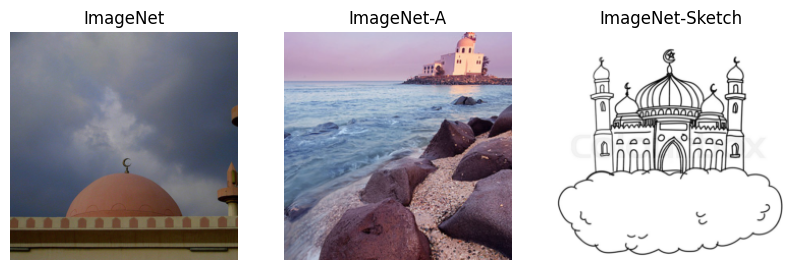

In [6]:
# edit these paths to try the experiment on other images
inet_path = 'val/n03788195/ILSVRC2012_val_00026188.JPEG'
inet_a_path = 'imagenet-a/n03788195/0.000251_stingray _ stingray_0.7409649.jpg'
sketch_path = 'sketch/n03788195/sketch_26.JPEG'

inet_img = Image.open(inet_path).convert('RGB')
inet_a_img = Image.open(inet_a_path).convert('RGB')
sketch_img = Image.open(sketch_path).convert('RGB')

vis_inet_img = vfs.data.vis_transform(inet_img)
vis_inet_a_img = vfs.data.vis_transform(inet_a_img)
vis_sketch_img = vfs.data.vis_transform(sketch_img)

cnn_inet_img = vfs.data.net_transform(inet_img)
cnn_inet_a_img = vfs.data.net_transform(inet_a_img)
cnn_sketch_img = vfs.data.net_transform(sketch_img)

# visualize the three images
plt.subplot(1,3,1)
plt.imshow(vis_inet_img, cmap='gray')
plt.axis('off')
plt.title('ImageNet')
plt.subplot(1,3,2)
plt.imshow(vis_inet_a_img, cmap='gray')
plt.axis('off')
plt.title('ImageNet-A')
plt.subplot(1,3,3)
plt.imshow(vis_sketch_img, cmap='gray')
plt.axis('off')
plt.title('ImageNet-Sketch')

Then, we highlight the same canonical part in each query image (i.e. the dome on a mosque).

In [7]:
inet_callback_data = None
def inet_highlight(data):
    global inet_callback_data
    inet_callback_data = data
vfs.util.create_callback('inet_highlight', inet_highlight)

print('ImageNet Mosque:')
vfs.widgets.HighlightWidget(vfs.util.image_to_durl(vis_inet_img), callback_name='inet_highlight')

ImageNet Mosque:


In [8]:
inet_a_callback_data = None
def inet_a_highlight(data):
    global inet_a_callback_data
    inet_a_callback_data = data
vfs.util.create_callback('inet_a_highlight', inet_a_highlight)

print("ImageNet-A Mosque:")
vfs.widgets.HighlightWidget(vfs.util.image_to_durl(vis_inet_a_img), callback_name='inet_a_highlight')

ImageNet-A Mosque:


In [9]:
sketch_callback_data = None
def sketch_highlight(data):
    global sketch_callback_data
    sketch_callback_data = data
vfs.util.create_callback('sketch_highlight', sketch_highlight)

print("ImageNet-Sketch Mosque:")
vfs.widgets.HighlightWidget(vfs.util.image_to_durl(vis_sketch_img), callback_name='sketch_highlight')

ImageNet-Sketch Mosque:


We then search for the most similar regions as encoded in a ResNet50 conv5 features for each of the highlighted regions from the query images.

In [10]:
assert inet_callback_data is not None, "1st widget needs a highlighted region"
assert inet_a_callback_data is not None, "2nd widget needs a highlighted region"
assert sketch_callback_data is not None, "3rd widget needs a highlighted region"

conv5_transform = transforms.Resize(CONV5_FEATURE_SIZE)

# assemble masks (downsample to 7x7 and convert to grayscale)
inet_mask = vfs.util.durl_to_image(inet_callback_data)
inet_mask_small = conv5_transform(inet_mask)
inet_mask_arr = np.asarray(inet_mask_small)[:,:,3] / 255

inet_a_mask = vfs.util.durl_to_image(inet_a_callback_data)
inet_a_mask_small = conv5_transform(inet_a_mask)
inet_a_mask_arr = np.asarray(inet_a_mask_small)[:,:,3] / 255

sketch_mask = vfs.util.durl_to_image(sketch_callback_data)
sketch_mask_small = conv5_transform(sketch_mask)
sketch_mask_arr = np.asarray(sketch_mask_small)[:,:,3] / 255

# compute the similarities
print('Loading Results...')

# ImageNet
cached_search_tool.set_input_image(cnn_inet_img)
inet_sims, inet_xs, inet_ys = cached_search_tool.compute(inet_mask_arr)
inet_order = torch.argsort(inet_sims, descending=True)

# ImageNet-A
cached_search_tool.set_input_image(cnn_inet_a_img)
inet_a_sims, inet_a_xs, inet_a_ys = cached_search_tool.compute(inet_a_mask_arr)
inet_a_order = torch.argsort(inet_a_sims, descending=True)

# ImageNet-Sketch
cached_search_tool.set_input_image(cnn_sketch_img)
sketch_sims, sketch_xs, sketch_ys = cached_search_tool.compute(sketch_mask_arr)
sketch_order = torch.argsort(sketch_sims, descending=True)

print('Done.')

Loading Results...
Done.


Finally, we show the most similar regions to each of the 3 query images.

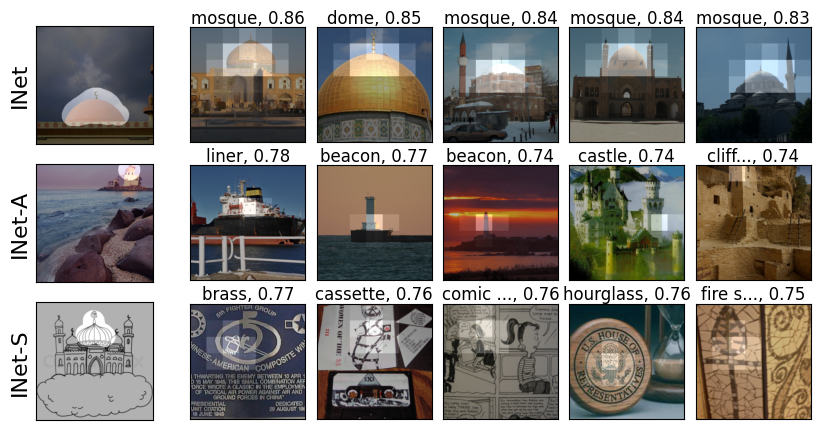

In [12]:
# set up the figure
DISPLAY_NUM = 5
TEXT_CUTOFF = 6

toTensor = transforms.ToTensor()

fig = plt.figure(figsize=(10, 5.15), dpi=100)
gs = fig.add_gridspec(1,2, width_ratios=[0.95,5])
fig.subplots_adjust(wspace=0.1, hspace=0.15)

queries_gs = gs[0].subgridspec(3,1)
results_gs = gs[1].subgridspec(3,DISPLAY_NUM)

# show the query region on the left-hand side
ax = fig.add_subplot(queries_gs[0])
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(vfs.util.mask_overlay(vis_inet_img, 0, 0, 224, np.asarray(inet_mask)[:,:,3] / 256))
ax.set_ylabel('INet', fontsize=16)

ax = fig.add_subplot(queries_gs[1])
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(vfs.util.mask_overlay(vis_inet_a_img, 0, 0, 224, np.asarray(inet_a_mask)[:,:,3] / 256))
ax.set_ylabel('INet-A', fontsize=16)

ax = fig.add_subplot(queries_gs[2])
# ax.axis('off')
ax.imshow(vfs.util.mask_overlay(vis_sketch_img, 0, 0, 224, np.asarray(sketch_mask)[:,:,3] / 256))
ax.set_xticks([])
ax.set_yticks([])
ax.set_ylabel('INet-S', fontsize=16)

for i in range(DISPLAY_NUM):
  # imagenet
  idx = inet_order[i+1] # ignore first result, which will be the query image
  curr_img_out = vfs.util.mask_overlay(vis_imagenet_dataset[idx][0],
                                   inet_xs[idx],
                                   inet_ys[idx],
                                   7,
                                   vfs.util.crop_mask(inet_mask_arr), alpha=0.6, beta=0.5)

  ax = fig.add_subplot(results_gs[0,i])
  ax.set_xticks([])
  ax.set_yticks([])
  ax.imshow(curr_img_out, cmap='gray') # use cmap in case image is only 1-channel

  gt_label = imagenet_labels[int(idx) // 50].split(',')[0]
  if len(gt_label) > TEXT_CUTOFF+2:
    gt_label = gt_label[:TEXT_CUTOFF] + '...'
  sim_str = str(np.round(inet_sims[idx].cpu().numpy(), 2))
  new_title = gt_label + ', ' + sim_str
  ax.set_title(new_title, fontsize=12, pad=2)

  # imagenet-a
  idx = inet_a_order[i]
  curr_img_out = vfs.util.mask_overlay(vis_imagenet_dataset[idx][0],
                                   inet_a_xs[idx],
                                   inet_a_ys[idx],
                                   7,
                                   vfs.util.crop_mask(inet_a_mask_arr), beta=0.5)

  ax = fig.add_subplot(results_gs[1,i])
  ax.set_xticks([])
  ax.set_yticks([])
  ax.imshow(curr_img_out, cmap='gray')

  gt_label = imagenet_labels[int(idx) // 50].split(',')[0]
  if len(gt_label) > TEXT_CUTOFF+2:
    gt_label = gt_label[:TEXT_CUTOFF-1] + '...'
  sim_str = str(np.round(inet_a_sims[idx].cpu().numpy(), 2))
  new_title = gt_label + ', ' + sim_str
  ax.set_title(new_title, fontsize=12, pad=2)

  # imagenet-sketch
  idx = sketch_order[i]
  curr_img_out = vfs.util.mask_overlay(vis_imagenet_dataset[idx][0],
                                   sketch_xs[idx],
                                   sketch_ys[idx],
                                   7,
                                   vfs.util.crop_mask(sketch_mask_arr),
                                   beta=0.4, alpha=0.8)


  ax = fig.add_subplot(results_gs[2,i])
  ax.set_xticks([])
  ax.set_yticks([])
  ax.imshow(curr_img_out, cmap='gray')

  gt_label = imagenet_labels[int(idx) // 50].split(',')[0]
  if len(gt_label) > TEXT_CUTOFF+3:
    gt_label = gt_label[:TEXT_CUTOFF] + '...'
  sim_str = str(np.round(sketch_sims[idx].cpu().numpy(), 2))
  new_title = gt_label + ', ' + sim_str
  ax.set_title(new_title, fontsize=12, pad=2)

The visualization above shows that the out-of-domain images (rows **b** and **c**) have lower cosine similarity scores than those of the in-domain images (row **a**), and they often possess a different ground-truth label than that of the query image. For instance, notice how the mosque ImageNet-Sketch results (row **c**) shows nearest neighbors that are other illustrations, rather than other mosque buildings.